<a href="https://colab.research.google.com/github/jhou27/MachineLearning_with_Python/blob/main/Image_classification_NN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models
# from torch.utils.data import SubsetRandomSampler
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

In [25]:
final_test=pd.read_csv('/content/drive/My Drive/coding/data/test_nn_pytorch.csv', dtype=np.float32)
train=pd.read_csv('/content/drive/My Drive/coding/data/train_nn_pytorch.csv',dtype=np.float32)

In [14]:
# Seperate the features and labels
targets_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

In [15]:
# create feature and targets tensor for train set. 
#As you remember we need variable to accumulate gradients. 
#Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor) # data type is long

In [16]:
# Set batch size
batch_size = 256

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

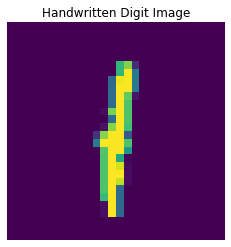

In [17]:
# visualize one of the images in data set
def visualize_image(data, index, pred=False, val=0):
    '''This funtion can be used to visualize the images'''
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title("Handwritten Digit Image")
    plt.show()
visualize_image(features_np, 12)

In [18]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

In [19]:
# Instantiate our model
model = Classifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/25..  Training Loss: 0.429..  Test Loss: 0.405..  Test Accuracy: 0.877
Epoch: 1/25..  Training Loss: 0.573..  Test Loss: 0.283..  Test Accuracy: 0.911
Epoch: 2/25..  Training Loss: 0.035..  Test Loss: 0.214..  Test Accuracy: 0.932
Epoch: 2/25..  Training Loss: 0.117..  Test Loss: 0.174..  Test Accuracy: 0.948
Epoch: 2/25..  Training Loss: 0.193..  Test Loss: 0.163..  Test Accuracy: 0.951
Epoch: 3/25..  Training Loss: 0.043..  Test Loss: 0.143..  Test Accuracy: 0.957
Epoch: 3/25..  Training Loss: 0.096..  Test Loss: 0.130..  Test Accuracy: 0.962
Epoch: 4/25..  Training Loss: 0.003..  Test Loss: 0.131..  Test Accuracy: 0.961
Epoch: 4/25..  Training Loss: 0.048..  Test Loss: 0.116..  Test Accuracy: 0.966
Epoch: 4/25..  Training Loss: 0.091..  Test Loss: 0.106..  Test Accuracy: 0.968
Epoch: 5/25..  Training Loss: 0.015..  Test Loss: 0.111..  Test Accuracy: 0.969
Epoch: 5/25..  Training Loss: 0.049..  Test Loss: 0.112..  Test Accuracy: 0.967
Epoch: 5/25..  Training Loss: 0.087..  T

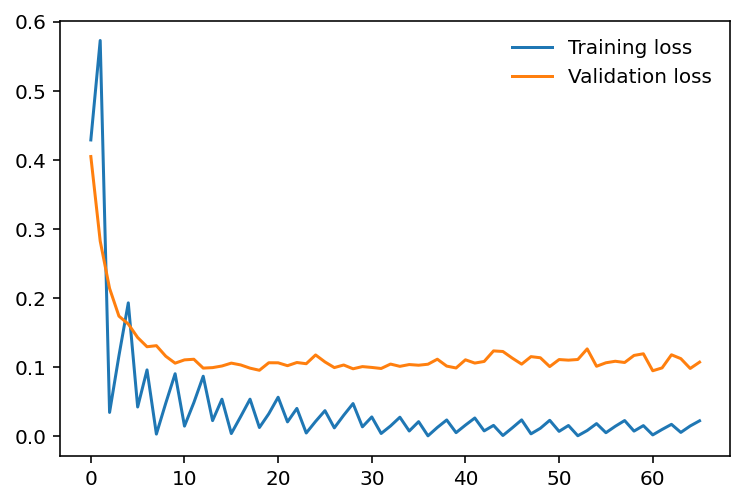

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [22]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


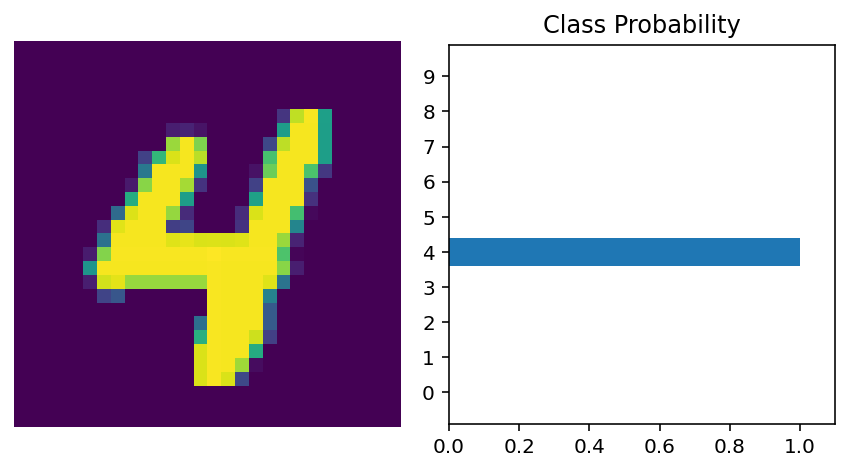

In [23]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[42].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(test_loader)

In [26]:
final_test_np = final_test.values/255
test_tn = torch.from_numpy(final_test_np)

In [27]:
# Creating fake labels for convenience of passing into DataLoader
## CAUTION: There are other ways of doing this, I just did it this way
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [28]:
submission_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)

submission_loader = torch.utils.data.DataLoader(submission_tn_data, batch_size = batch_size, shuffle = False)

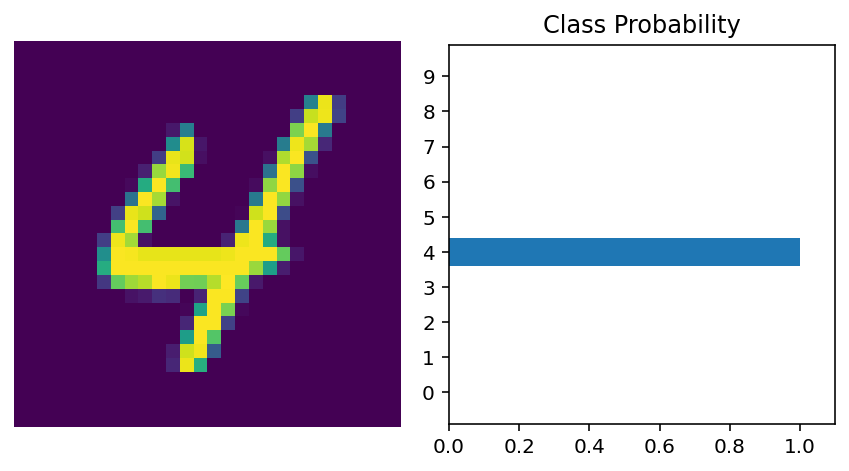

In [29]:
# Seeing what our model does on test data
make_prediction(submission_loader)

In [30]:
# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in submission_loader:
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1

In [31]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)

In [32]:
submission_df

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3
...,...,...
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9
